In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### 1) Define the relationship between the NTN-B yield and the BR10YT

##### Find the correlation between them: 96%

In [2]:
df = pd.read_csv('yield-correlation.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%b-%y')
df.set_index('date', inplace=True)

In [4]:
correlation_matrix = df.corr()
correlation_matrix

,ntnb_5yr_yield,cpi_ipca,yr10_gov_bond_yield
ntnb_5yr_yield,1.000000,0.354614,0.962594
cpi_ipca,0.354614,1.000000,0.490069
yr10_gov_bond_yield,0.962594,0.490069,1.000000


##### Stationarity (Dickey-Fuller test) and autocorrelation of residuals

In [5]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [6]:
adf_ntnb_yield = adfuller(df['ntnb_5yr_yield'])
adf_cpi_ipca = adfuller(df['cpi_ipca'])
adf_yr10_gov_bond_yield = adfuller(df['yr10_gov_bond_yield'])

In [7]:
adf_results = {
    'ntnb_5yr_yield': adf_ntnb_yield[1],  # p-value
    'cpi_ipca': adf_cpi_ipca[1],          # p-value
    'yr10_gov_bond_yield': adf_yr10_gov_bond_yield[1]  # p-value
}

In [8]:
X = sm.add_constant(df['yr10_gov_bond_yield'])
model = sm.OLS(df['ntnb_5yr_yield'], X).fit()
residuals = model.resid

<Figure size 1000x600 with 0 Axes>

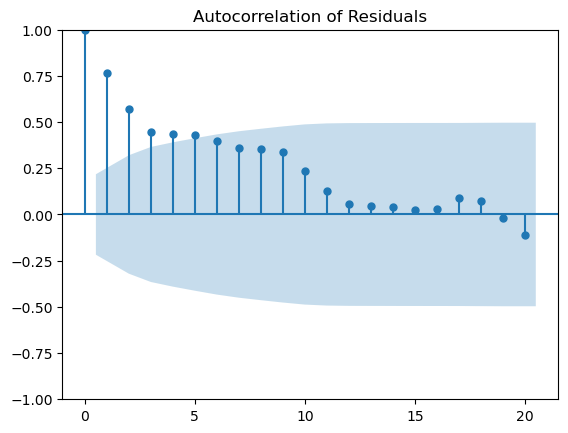

{'ntnb_5yr_yield': 0.8706258014592814,
 'cpi_ipca': 0.6444899896324753,
 'yr10_gov_bond_yield': 0.5918762157936057}

In [9]:
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals, lags=20, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.show()

adf_results

In [10]:
df['diff_ntnb_5yr_yield'] = df['ntnb_5yr_yield'].diff().dropna()
df['diff_yr10_gov_bond_yield'] = df['yr10_gov_bond_yield'].diff().dropna()

In [11]:
df_diff = df.dropna(subset=['diff_ntnb_5yr_yield', 'diff_yr10_gov_bond_yield'])

In [12]:
adf_ntnb_diff = adfuller(df_diff['diff_ntnb_5yr_yield'])
adf_yr10_gov_diff = adfuller(df_diff['diff_yr10_gov_bond_yield'])

In [13]:
X_diff = sm.add_constant(df_diff['diff_yr10_gov_bond_yield'])
model_diff = sm.OLS(df_diff['diff_ntnb_5yr_yield'], X_diff).fit()

In [14]:
residuals_diff = model_diff.resid

<Figure size 1000x600 with 0 Axes>

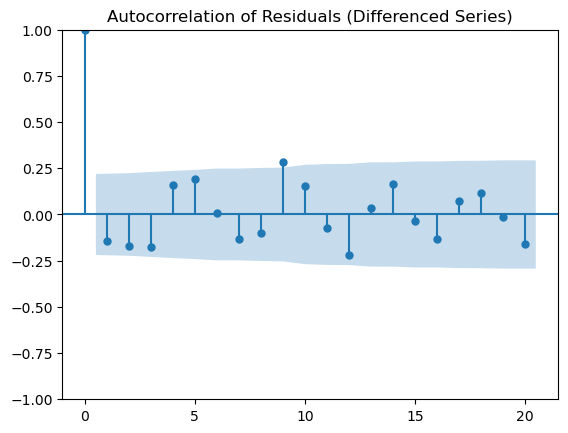

In [15]:
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals_diff, lags=20, alpha=0.05)
plt.title('Autocorrelation of Residuals (Differenced Series)')
plt.show()

In [16]:
adf_diff_results = {
    'diff_ntnb_5yr_yield': adf_ntnb_diff[1],  # p-value
    'diff_yr10_gov_bond_yield': adf_yr10_gov_diff[1]  # p-value
}

In [17]:
model_diff_summary = model_diff.summary()
adf_diff_results, model_diff_summary

({'diff_ntnb_5yr_yield': 3.2469943886149468e-12,
  'diff_yr10_gov_bond_yield': 4.5221297702752256e-10},
 <class 'statsmodels.iolib.summary.Summary'>
 """
                              OLS Regression Results                            
 Dep. Variable:     diff_ntnb_5yr_yield   R-squared:                       0.614
 Model:                             OLS   Adj. R-squared:                  0.609
 Method:                  Least Squares   F-statistic:                     124.1
 Date:                 Mon, 23 Dec 2024   Prob (F-statistic):           8.47e-18
 Time:                         11:42:21   Log-Likelihood:                 15.086
 No. Observations:                   80   AIC:                            -26.17
 Df Residuals:                       78   BIC:                            -21.41
 Df Model:                            1                                         
 Covariance Type:             nonrobust                                         
                                coef

#### 2) Scenario-building: Average yields and IPCA inflation for the year 2029

In [18]:
#Initial Yield and Inflation Rates
initial_yield = 11.4 # 2024 average for the 10-year government bond yield (January 2024 to June 2024)
initial_inflation = 4.4 # 2024 average inflation rate (CPI IPCA YoY from July 2023 to June 2024)

In [19]:
# Target Yields for 2029
flat_yield = initial_yield
upward_yield = 16.49
downward_yield = 6.3

In [20]:
# Target Inflation for 2029
flat_inflation = initial_inflation
upward_inflation = 6.3 # Average inflation for the past 24 years
downward_inflation = 3.4 # Average of lowest three-year period of Inflation (2017-2020)

In [21]:
#Number of months from July 2024 to December 2029
n_months = 66

In [22]:
#Calculating the monthly changes required to reach the target
mchange_upward_y = (upward_yield - initial_yield) / (n_months - 6) #Subtraction of 6 months because the last year (2029) needs to be the average target
mchange_downward_y = (downward_yield - initial_yield) / (n_months - 6)
mchange_flat_y = 0  # Flat scenario yield remains constant 

In [23]:
#Calculating the monthly changes required to reach the target inflation
mchange_upward_ipca = (upward_inflation - initial_inflation) / (n_months - 6)
mchange_downward_ipca = (downward_inflation - initial_inflation) / (n_months - 6)
mchange_flat_ipca = 0  # Flat scenario inflation remains constant 

In [24]:
#Generating a date range from July 2024 to December 2029
dates = pd.date_range(start='2024-07-01', end='2029-12-01', freq='MS')

In [25]:
#Projecting yield values for each scenario
projected_yields = pd.DataFrame({'Date': dates})

#Yields for each scenario
projected_yields['Flat_10YR_Yield'] = initial_yield
projected_yields['Upward_10YR_Yield'] = initial_yield + mchange_upward_y * np.arange(1, len(dates) + 1)
projected_yields['Downward_10YR_Yield'] = initial_yield + mchange_downward_y * np.arange(1, len(dates) + 1)

#Inflation for each scenario
projected_yields['Flat_Inflation'] = initial_inflation
projected_yields['Upward_Inflation'] = initial_inflation + mchange_upward_ipca * np.arange(1, len(dates) + 1)
projected_yields['Downward_Inflation'] = initial_inflation + mchange_downward_ipca * np.arange(1, len(dates) + 1)

In [26]:
avg_yield_inflation_2029 = projected_yields[projected_yields['Date'].dt.year == 2029].mean()
print(avg_yield_inflation_2029)

Date                   2029-06-16 12:00:00
Flat_10YR_Yield                       11.4
Upward_10YR_Yield                16.532417
Downward_10YR_Yield                 6.2575
Flat_Inflation                         4.4
Upward_Inflation                  6.315833
Downward_Inflation                3.391667
dtype: object


#### 3) Knowing NTN-B relationship and the projected yield of BR10YT, model the monthly changes for it

In [27]:
ntnb_factor = 0.43 #Results from regression

In [28]:
projected_yields['NTNB_Change_Flat'] = (projected_yields['Flat_10YR_Yield'] - initial_yield) * ntnb_factor
projected_yields['NTNB_Change_Upward'] = (projected_yields['Upward_10YR_Yield'] - initial_yield) * ntnb_factor
projected_yields['NTNB_Change_Downward'] = (projected_yields['Downward_10YR_Yield'] - initial_yield) * ntnb_factor

In [29]:
projected_yields.tail(12) 

,Date,Flat_10YR_Yield,Upward_10YR_Yield,Downward_10YR_Yield,Flat_Inflation,Upward_Inflation,Downward_Inflation,NTNB_Change_Flat,NTNB_Change_Upward,NTNB_Change_Downward
54,2029-01-01,11.4,16.065833,6.725,4.4,6.141667,3.483333,0.0,2.006308,-2.01025
55,2029-02-01,11.4,16.150667,6.640,4.4,6.173333,3.466667,0.0,2.042787,-2.04680
56,2029-03-01,11.4,16.235500,6.555,4.4,6.205000,3.450000,0.0,2.079265,-2.08335
57,2029-04-01,11.4,16.320333,6.470,4.4,6.236667,3.433333,0.0,2.115743,-2.11990
58,2029-05-01,11.4,16.405167,6.385,4.4,6.268333,3.416667,0.0,2.152222,-2.15645
59,2029-06-01,11.4,16.490000,6.300,4.4,6.300000,3.400000,0.0,2.188700,-2.19300
60,2029-07-01,11.4,16.574833,6.215,4.4,6.331667,3.383333,0.0,2.225178,-2.22955
61,2029-08-01,11.4,16.659667,6.130,4.4,6.363333,3.366667,0.0,2.261657,-2.26610
62,2029-09-01,11.4,16.744500,6.045,4.4,6.395000,3.350000,0.0,2.298135,-2.30265
63,2029-10-01,11.4,16.829333,5.960,4.4,6.426667,3.333333,0.0,2.334613,-2.33920


In [30]:
#Establishing the starting point for the NTN-B bond yield
jan_to_june_2024 = df[(df.index >= '2024-01-01') & (df.index <= '2024-06-30')]
ntnb_yield_2024 = jan_to_june_2024['ntnb_5yr_yield'].mean()
print(ntnb_yield_2024)

5.973333333333333


In [31]:
#Projecting the NTN-B yields for each scenario starting from the January-June 2024 average
projected_yields['NTNB_Flat_Scenario'] = ntnb_yield_2024 + projected_yields['NTNB_Change_Flat']
projected_yields['NTNB_Upward_Scenario'] = ntnb_yield_2024 + projected_yields['NTNB_Change_Upward']
projected_yields['NTNB_Downward_Scenario'] = ntnb_yield_2024 + projected_yields['NTNB_Change_Downward']

In [32]:
projected_yields.to_csv('projected_ntnb_yields.csv', index=False)

#### 4) Finish by Building the BNDES with NTN-B yield and inflation

In [33]:
# Initialize columns for BNDES rates
projected_yields['BNDES_Flat'] = np.nan
projected_yields['BNDES_Upward'] = np.nan
projected_yields['BNDES_Downward'] = np.nan

# Calculating the BNDES rate starting from October 2024
for i in range(3, len(projected_yields)):  # As the BNDES rate is calculated as the average 3 previous month NTN-B yield, we need to start in October
    if projected_yields['Date'].iloc[i] >= pd.Timestamp('2024-10-01'):
        # Calculating BNDES for the Flat Scenario
        flat_ntnb_avg = projected_yields['NTNB_Flat_Scenario'].iloc[i-3:i].mean()
        flat_inflation = projected_yields['Flat_Inflation'].iloc[i]
        projected_yields.at[projected_yields.index[i], 'BNDES_Flat'] = flat_ntnb_avg + flat_inflation
        
        # Calculating BNDES for the Upward Scenario
        upward_ntnb_avg = projected_yields['NTNB_Upward_Scenario'].iloc[i-3:i].mean()
        upward_inflation = projected_yields['Upward_Inflation'].iloc[i]
        projected_yields.at[projected_yields.index[i], 'BNDES_Upward'] = upward_ntnb_avg + upward_inflation
        
        # Calculating BNDES for the Downward Scenario
        downward_ntnb_avg = projected_yields['NTNB_Downward_Scenario'].iloc[i-3:i].mean()
        downward_inflation = projected_yields['Downward_Inflation'].iloc[i]
        projected_yields.at[projected_yields.index[i], 'BNDES_Downward'] = downward_ntnb_avg + downward_inflation

In [34]:
initial_bndes = 10.373333

In [35]:
# Yearly averages 
projected_yields['Year'] = projected_yields['Date'].dt.year

# Grouping by year and calculating the average for NTN-B Yields, Inflation Rates, BNDES rates
scenarios_solar = projected_yields.groupby('Year').mean()

In [36]:
# 2024 averages assigned to initial starting values for both NTN-B Yield and Inflation for all scenarios
scenarios_solar.loc[2024, ['NTNB_Flat_Scenario', 'NTNB_Upward_Scenario', 'NTNB_Downward_Scenario']] = ntnb_yield_2024
scenarios_solar.loc[2024, ['Flat_Inflation', 'Upward_Inflation', 'Downward_Inflation']] = initial_inflation
scenarios_solar.loc[2024, ['BNDES_Flat', 'BNDES_Upward', 'BNDES_Downward']] = initial_bndes

# Combined yearly averages
scenarios_solar[['NTNB_Flat_Scenario', 'NTNB_Upward_Scenario', 'NTNB_Downward_Scenario',
                 'Flat_Inflation', 'Upward_Inflation', 'Downward_Inflation',  
                 'BNDES_Flat', 'BNDES_Upward', 'BNDES_Downward']].head(6)

,NTNB_Flat_Scenario,NTNB_Upward_Scenario,NTNB_Downward_Scenario,Flat_Inflation,Upward_Inflation,Downward_Inflation,BNDES_Flat,BNDES_Upward,BNDES_Downward
Year,,,,,,,,,
2024,5.973333,5.973333,5.973333,4.4,4.400000,4.400000,10.373333,10.373333,10.373333
2025,5.973333,6.429312,5.516458,4.4,4.795833,4.191667,10.373333,11.152189,9.781225
2026,5.973333,6.867052,5.077858,4.4,5.175833,3.991667,10.373333,11.969929,9.142625
2027,5.973333,7.304792,4.639258,4.4,5.555833,3.791667,10.373333,12.787669,8.504025
2028,5.973333,7.742532,4.200658,4.4,5.935833,3.591667,10.373333,13.605409,7.865425
2029,5.973333,8.180272,3.762058,4.4,6.315833,3.391667,10.373333,14.423149,7.226825


#### 5) Once the BNDES rate components is calculated, we construct the WACC

In [37]:
technology_premium = 1.5      # 1.5%
equity_premium = 4.27         # 4.27%
leverage = 0.8                  # Leverage ratio (D/V)
tax_rate = 0.34                 # Corporate tax rate

In [38]:
def calculate_cost_of_debt(bndes_rate):
    return bndes_rate + technology_premium

# Applying the cost of debt calculation for each scenario
scenarios_solar['Cost_of_Debt_Flat'] = calculate_cost_of_debt(scenarios_solar['BNDES_Flat'])
scenarios_solar['Cost_of_Debt_Upward'] = calculate_cost_of_debt(scenarios_solar['BNDES_Upward'])
scenarios_solar['Cost_of_Debt_Downward'] = calculate_cost_of_debt(scenarios_solar['BNDES_Downward'])

scenarios_solar[['BNDES_Flat', 'BNDES_Upward', 'BNDES_Downward', 
                 'Cost_of_Debt_Flat', 'Cost_of_Debt_Upward', 'Cost_of_Debt_Downward']].head(6)

,BNDES_Flat,BNDES_Upward,BNDES_Downward,Cost_of_Debt_Flat,Cost_of_Debt_Upward,Cost_of_Debt_Downward
Year,,,,,,
2024,10.373333,10.373333,10.373333,11.873333,11.873333,11.873333
2025,10.373333,11.152189,9.781225,11.873333,12.652189,11.281225
2026,10.373333,11.969929,9.142625,11.873333,13.469929,10.642625
2027,10.373333,12.787669,8.504025,11.873333,14.287669,10.004025
2028,10.373333,13.605409,7.865425,11.873333,15.105409,9.365425
2029,10.373333,14.423149,7.226825,11.873333,15.923149,8.726825


In [39]:
def calculate_cost_of_equity(bndes_rate):
    return bndes_rate + equity_premium + technology_premium

In [40]:
scenarios_solar['Cost_of_Equity_Flat'] = calculate_cost_of_equity(scenarios_solar['BNDES_Flat'])
scenarios_solar['Cost_of_Equity_Upward'] = calculate_cost_of_equity(scenarios_solar['BNDES_Upward'])
scenarios_solar['Cost_of_Equity_Downward'] = calculate_cost_of_equity(scenarios_solar['BNDES_Downward'])

scenarios_solar[['BNDES_Flat', 'BNDES_Upward', 'BNDES_Downward', 
                 'Cost_of_Equity_Flat', 'Cost_of_Equity_Upward', 'Cost_of_Equity_Downward']].head(6)

,BNDES_Flat,BNDES_Upward,BNDES_Downward,Cost_of_Equity_Flat,Cost_of_Equity_Upward,Cost_of_Equity_Downward
Year,,,,,,
2024,10.373333,10.373333,10.373333,16.143333,16.143333,16.143333
2025,10.373333,11.152189,9.781225,16.143333,16.922189,15.551225
2026,10.373333,11.969929,9.142625,16.143333,17.739929,14.912625
2027,10.373333,12.787669,8.504025,16.143333,18.557669,14.274025
2028,10.373333,13.605409,7.865425,16.143333,19.375409,13.635425
2029,10.373333,14.423149,7.226825,16.143333,20.193149,12.996825


In [41]:
def calculate_wacc(cost_of_debt, cost_of_equity):
    wacc = (leverage * cost_of_debt * (1- tax_rate)) + ((1- leverage) * cost_of_equity)
    return wacc
    

scenarios_solar['WACC_Flat'] = calculate_wacc(scenarios_solar['Cost_of_Debt_Flat'], scenarios_solar['Cost_of_Equity_Flat'])
scenarios_solar['WACC_Upward'] = calculate_wacc(scenarios_solar['Cost_of_Debt_Upward'], scenarios_solar['Cost_of_Equity_Upward'])
scenarios_solar['WACC_Downward'] = calculate_wacc(scenarios_solar['Cost_of_Debt_Downward'], scenarios_solar['Cost_of_Equity_Downward'])

scenarios_solar[['WACC_Flat', 'WACC_Upward', 'WACC_Downward']]

,WACC_Flat,WACC_Upward,WACC_Downward
Year,,,
2024,9.497786,9.497786,9.497786
2025,9.497787,10.064794,9.066732
2026,9.497787,10.660108,8.601831
2027,9.497787,11.255423,8.136930
2028,9.497787,11.850738,7.672029
2029,9.497787,12.446053,7.207129


#### 6) After the WACC, build the LCOE: Schmmidt et al. (2019) add a learning curve of 15%

In [42]:
capex_2022 = 167735285.6  # in nominal BRL for 2022
opex_2022 = 2430484.3  #EPE report 1.45%
capex_learning_rate = 0.15
opex_learning_rate = 0.05
inflation_rate = 0.04  # 4% annual inflation
nominal_power = 40  # Average MW for 2022
capacity_factor = 0.313447745 #Average 2022
lifetime = 25  # Project lifetime in years
hours_per_year = 8760  # Total hours in a year

In [43]:
# Capacity totals for each year starting from 2023
capacity_total = {
    2023: 1628,
    2024: 2167,
    2025: 2781,
    2026: 3469,
    2027: 4241,
    2028: 5117,
    2029: 6000
}

In [44]:
years = list(capacity_total.keys())
capex_values = []
projected_opex_values = []

for year in years:
    capex = capex_2022 * (capacity_total[year] / capacity_total[2023]) ** (np.log(1 - capex_learning_rate) / np.log(2))
    capex_values.append(capex)
    opex = opex_2022 * (capacity_total[year] / capacity_total[2023]) ** (np.log(1 - opex_learning_rate) / np.log(2))
    projected_opex_values.append(opex)

In [45]:
# Filtering out the 2023 values to match the DataFrame
projected_capex = capex_values[1:]  
projected_opex = projected_opex_values[1:]

# Adding the calculated CAPEX and OPEX (from 2024 onwards) directly to the DataFrame
scenarios_solar['Projected_CAPEX'] = pd.Series(projected_capex, index=scenarios_solar.index)
scenarios_solar['Projected_OPEX'] = pd.Series(projected_opex, index=scenarios_solar.index)

# Display the updated DataFrame to verify the integration
scenarios_solar[['Projected_CAPEX', 'Projected_OPEX']].head(6)

,Projected_CAPEX,Projected_OPEX
Year,,
2024,1.568566e+08,2.379587e+06
2025,1.479450e+08,2.336061e+06
2026,1.404724e+08,2.298158e+06
2027,1.340079e+08,2.264239e+06
2028,1.282362e+08,2.232995e+06
2029,1.235380e+08,2.206844e+06


In [46]:
def calculate_opex_inflated(opex_yearly, inflation_rate, lifetime):
    return [opex_yearly * ((1 + inflation_rate) ** t) for t in range(1, lifetime + 1)]

In [47]:
scenarios_solar['Inflated_OPEX'] = scenarios_solar['Projected_OPEX'].apply(
    lambda opex: calculate_opex_inflated(opex, inflation_rate, lifetime)
)

scenarios_solar[['Projected_OPEX', 'Inflated_OPEX']].head(6)

,Projected_OPEX,Inflated_OPEX
Year,,
2024,2.379587e+06,"[2474770.6303092097, 2573761.4555215784, 26767..."
2025,2.336061e+06,"[2429503.7659445363, 2526683.916582318, 262775..."
2026,2.298158e+06,"[2390084.6118369806, 2485687.99631046, 2585115..."
2027,2.264239e+06,"[2354809.021940412, 2449001.382818029, 2546961..."
2028,2.232995e+06,"[2322315.147665047, 2415207.753571649, 2511816..."
2029,2.206844e+06,"[2295118.2326915665, 2386922.961999229, 248239..."


In [48]:
def calculate_total_inflated_opex(opex_yearly, inflation_rate, lifetime):
    inflated_opex = calculate_opex_inflated(opex_yearly, inflation_rate, lifetime)
    return sum(inflated_opex)

scenarios_solar['Total_Inflated_OPEX'] = scenarios_solar['Projected_OPEX'].apply(
    lambda opex: calculate_total_inflated_opex(opex, inflation_rate, lifetime)
)

scenarios_solar[['Projected_OPEX', 'Total_Inflated_OPEX']].head()

,Projected_OPEX,Total_Inflated_OPEX
Year,,
2024,2.379587e+06,1.030641e+08
2025,2.336061e+06,1.011789e+08
2026,2.298158e+06,9.953724e+07
2027,2.264239e+06,9.806816e+07
2028,2.232995e+06,9.671492e+07


##### OPEX Baseline

In [49]:
# Calculated expected energy production (MWh per year)
exp_energy_prod = nominal_power * capacity_factor * hours_per_year

In [50]:
def calculate_opex_baseline(total_inflated_opex, exp_energy_prod, lifetime):
    total_energy_prod = exp_energy_prod * lifetime  # Total energy production over 25 years
    opex_baseline = total_inflated_opex / total_energy_prod  # OPEX baseline contribution to LCOE
    return opex_baseline

In [51]:
scenarios_solar['OPEX_Baseline'] = scenarios_solar.apply(
    lambda row: calculate_opex_baseline(row['Total_Inflated_OPEX'], exp_energy_prod, lifetime), axis=1
)

In [52]:
scenarios_solar[['Total_Inflated_OPEX', 'OPEX_Baseline']].head()

,Total_Inflated_OPEX,OPEX_Baseline
Year,,
2024,1.030641e+08,37.535140
2025,1.011789e+08,36.848572
2026,9.953724e+07,36.250697
2027,9.806816e+07,35.715668
2028,9.671492e+07,35.222829


##### CAPEX Baseline

In [53]:
def calculate_capex_baseline(capex, exp_energy_prod):
    total_energy_prod = exp_energy_prod * lifetime  # Total energy production over 25 years
    capex_baseline = capex / total_energy_prod  # CAPEX baseline contribution to LCOE
    return capex_baseline

In [54]:
scenarios_solar['CAPEX_Baseline'] = scenarios_solar.apply(
    lambda row: calculate_capex_baseline(row['Projected_CAPEX'], exp_energy_prod), axis=1
)

scenarios_solar[[ 'OPEX_Baseline', 'CAPEX_Baseline']].head(6)

,OPEX_Baseline,CAPEX_Baseline
Year,,
2024,37.535140,57.125963
2025,36.848572,53.880434
2026,36.250697,51.158952
2027,35.715668,48.804658
2028,35.222829,46.702626
2029,34.810330,44.991591


##### LCOE Baseline (0% WACC) 2024-2029

In [55]:
scenarios_solar['LCOE_Baseline'] = scenarios_solar['OPEX_Baseline'] + scenarios_solar['CAPEX_Baseline']

In [56]:
scenarios_solar[['OPEX_Baseline', 'CAPEX_Baseline', 'LCOE_Baseline']].head(6)

,OPEX_Baseline,CAPEX_Baseline,LCOE_Baseline
Year,,,
2024,37.535140,57.125963,94.661103
2025,36.848572,53.880434,90.729005
2026,36.250697,51.158952,87.409649
2027,35.715668,48.804658,84.520325
2028,35.222829,46.702626,81.925455
2029,34.810330,44.991591,79.801921


#### 7) Build the LCOE with WACC for the three scenarios

In [57]:
# Define the function for calculating discounted OPEX
def calculate_discounted_opex(opex_inflated, wacc, years=lifetime):
    discounted_opex = [opex_inflated[t-1] / ((1 + wacc) ** t) for t in range(1, years + 1)]
    total_discounted_opex = sum(discounted_opex)
    return total_discounted_opex

# Apply the function for each scenario (Flat, Upward, Downward)
scenarios_solar['Discounted_OPEX_Flat'] = scenarios_solar.apply(
    lambda row: calculate_discounted_opex(row['Inflated_OPEX'], row['WACC_Flat'] / 100), axis=1)

scenarios_solar['Discounted_OPEX_Upward'] = scenarios_solar.apply(
    lambda row: calculate_discounted_opex(row['Inflated_OPEX'], row['WACC_Upward'] / 100), axis=1)

scenarios_solar['Discounted_OPEX_Downward'] = scenarios_solar.apply(
    lambda row: calculate_discounted_opex(row['Inflated_OPEX'], row['WACC_Downward'] / 100), axis=1)

In [58]:
# Define the function for calculating discounted energy
def calculate_discounted_energy(annual_energy, wacc, years=lifetime):
    discounted_energy = [annual_energy / ((1 + wacc) ** t) for t in range(1, years + 1)]
    total_discounted_energy = sum(discounted_energy)
    return total_discounted_energy

# Apply the function for each scenario (Flat, Upward, Downward)
scenarios_solar['Discounted_Energy_Flat'] = scenarios_solar.apply(
    lambda row: calculate_discounted_energy(exp_energy_prod, row['WACC_Flat'] / 100), axis=1)

scenarios_solar['Discounted_Energy_Upward'] = scenarios_solar.apply(
    lambda row: calculate_discounted_energy(exp_energy_prod, row['WACC_Upward'] / 100), axis=1)

scenarios_solar['Discounted_Energy_Downward'] = scenarios_solar.apply(
    lambda row: calculate_discounted_energy(exp_energy_prod, row['WACC_Downward'] / 100), axis=1)

##### CAPEX with WACC for each scenario

In [59]:
# Calculate CAPEX with WACC for each scenario
scenarios_solar['CAPEX_WACC_Flat'] = scenarios_solar['Projected_CAPEX'] / scenarios_solar['Discounted_Energy_Flat']
scenarios_solar['CAPEX_WACC_Upward'] = scenarios_solar['Projected_CAPEX'] / scenarios_solar['Discounted_Energy_Upward']
scenarios_solar['CAPEX_WACC_Downward'] = scenarios_solar['Projected_CAPEX'] / scenarios_solar['Discounted_Energy_Downward']

##### OPEX with WACC for each scenario

In [60]:
# Calculate OPEX with WACC for each scenario
scenarios_solar['OPEX_WACC_Flat'] = scenarios_solar['Discounted_OPEX_Flat'] / scenarios_solar['Discounted_Energy_Flat']
scenarios_solar['OPEX_WACC_Upward'] = scenarios_solar['Discounted_OPEX_Upward'] / scenarios_solar['Discounted_Energy_Upward']
scenarios_solar['OPEX_WACC_Downward'] = scenarios_solar['Discounted_OPEX_Downward'] / scenarios_solar['Discounted_Energy_Downward']

##### Total LCOE with WACC for each scenario

In [61]:
scenarios_solar['LCOE_WACC_Flat'] = scenarios_solar['CAPEX_WACC_Flat'] + scenarios_solar['OPEX_WACC_Flat']
scenarios_solar['LCOE_WACC_Upward'] = scenarios_solar['CAPEX_WACC_Upward'] + scenarios_solar['OPEX_WACC_Upward']
scenarios_solar['LCOE_WACC_Downward'] = scenarios_solar['CAPEX_WACC_Downward'] + scenarios_solar['OPEX_WACC_Downward']

In [62]:
scenarios_solar[['LCOE_Baseline', 'LCOE_WACC_Flat', 'LCOE_WACC_Upward','LCOE_WACC_Downward']].head(6)

,LCOE_Baseline,LCOE_WACC_Flat,LCOE_WACC_Upward,LCOE_WACC_Downward
Year,,,,
2024,94.661103,182.740612,182.740612,182.740612
2025,90.729005,173.569656,179.728889,168.957855
2026,87.409649,165.860944,177.932398,156.843084
2027,84.520325,159.177377,176.708222,146.234089
2028,81.925455,153.197274,175.799433,136.742334
2029,79.801921,148.320031,175.774645,128.628774


#### 8) Financing Costs 2024-2029

In [63]:
# Calculating the financing cost for each scenario
scenarios_solar['Financing_Cost_Flat'] = scenarios_solar['LCOE_WACC_Flat'] - scenarios_solar['LCOE_Baseline']
scenarios_solar['Financing_Cost_Upward'] = scenarios_solar['LCOE_WACC_Upward'] - scenarios_solar['LCOE_Baseline']
scenarios_solar['Financing_Cost_Downward'] = scenarios_solar['LCOE_WACC_Downward'] - scenarios_solar['LCOE_Baseline']

scenarios_solar[['Financing_Cost_Flat', 'Financing_Cost_Upward', 'Financing_Cost_Downward']].head(6)

,Financing_Cost_Flat,Financing_Cost_Upward,Financing_Cost_Downward
Year,,,
2024,88.079509,88.079509,88.079509
2025,82.840651,88.999883,78.228850
2026,78.451295,90.522749,69.433435
2027,74.657051,92.187897,61.713764
2028,71.271819,93.873978,54.816879
2029,68.518109,95.972724,48.826853


#### 9) Data Visualization

In [64]:
# Calculate the total LCOE for each scenario
total_lcoe_flat = scenarios_solar['CAPEX_Baseline'] + scenarios_solar['OPEX_Baseline'] + scenarios_solar['Financing_Cost_Flat']
total_lcoe_upward = scenarios_solar['CAPEX_Baseline'] + scenarios_solar['OPEX_Baseline'] + scenarios_solar['Financing_Cost_Upward']
total_lcoe_downward = scenarios_solar['CAPEX_Baseline'] + scenarios_solar['OPEX_Baseline'] + scenarios_solar['Financing_Cost_Downward']

# Calculate the percentage contributions for the Flat scenario
capex_percentage_flat = (scenarios_solar['CAPEX_Baseline'] / total_lcoe_flat) * 100
opex_percentage_flat = (scenarios_solar['OPEX_Baseline'] / total_lcoe_flat) * 100
financing_percentage_flat = (scenarios_solar['Financing_Cost_Flat'] / total_lcoe_flat) * 100

# Calculate the percentage contributions for the Upward scenario
capex_percentage_upward = (scenarios_solar['CAPEX_Baseline'] / total_lcoe_upward) * 100
opex_percentage_upward = (scenarios_solar['OPEX_Baseline'] / total_lcoe_upward) * 100
financing_percentage_upward = (scenarios_solar['Financing_Cost_Upward'] / total_lcoe_upward) * 100

# Calculate the percentage contributions for the Downward scenario
capex_percentage_downward = (scenarios_solar['CAPEX_Baseline'] / total_lcoe_downward) * 100
opex_percentage_downward = (scenarios_solar['OPEX_Baseline'] / total_lcoe_downward) * 100
financing_percentage_downward = (scenarios_solar['Financing_Cost_Downward'] / total_lcoe_downward) * 100

# Add these percentages to the DataFrame (if desired for further use)
scenarios_solar['CAPEX_Percentage_Flat'] = capex_percentage_flat
scenarios_solar['OPEX_Percentage_Flat'] = opex_percentage_flat
scenarios_solar['Financing_Percentage_Flat'] = financing_percentage_flat

scenarios_solar['CAPEX_Percentage_Upward'] = capex_percentage_upward
scenarios_solar['OPEX_Percentage_Upward'] = opex_percentage_upward
scenarios_solar['Financing_Percentage_Upward'] = financing_percentage_upward

scenarios_solar['CAPEX_Percentage_Downward'] = capex_percentage_downward
scenarios_solar['OPEX_Percentage_Downward'] = opex_percentage_downward
scenarios_solar['Financing_Percentage_Downward'] = financing_percentage_downward

# Display the calculated percentages for verification
scenarios_solar[['CAPEX_Percentage_Flat', 'OPEX_Percentage_Flat', 'Financing_Percentage_Flat',
                 'CAPEX_Percentage_Upward', 'OPEX_Percentage_Upward', 'Financing_Percentage_Upward',
                 'CAPEX_Percentage_Downward', 'OPEX_Percentage_Downward', 'Financing_Percentage_Downward']].head(6)

,CAPEX_Percentage_Flat,OPEX_Percentage_Flat,Financing_Percentage_Flat,CAPEX_Percentage_Upward,OPEX_Percentage_Upward,Financing_Percentage_Upward,CAPEX_Percentage_Downward,OPEX_Percentage_Downward,Financing_Percentage_Downward
Year,,,,,,,,,
2024,31.260683,20.540119,48.199198,31.260683,20.540119,48.199198,31.260683,20.540119,48.199198
2025,31.042542,21.229847,47.727611,29.978727,20.502309,49.518964,31.889866,21.809327,46.300807
2026,30.844484,21.856078,47.299438,28.751904,20.373297,50.874799,32.617920,23.112716,44.269363
2027,30.660549,22.437653,46.901798,27.618781,20.211661,52.169557,33.374337,24.423626,42.202037
2028,30.485285,22.991812,46.522903,26.565857,20.035804,53.398339,34.153743,25.758540,40.087716
2029,30.334130,23.469743,46.196127,25.596178,19.803954,54.599868,34.977859,27.062631,37.959510


In [65]:
# Exchange rate for conversion
exchange_rate = 5.085634677

# Convert BRL values to USD
scenarios_solar['CAPEX_Baseline_USD'] = scenarios_solar['CAPEX_Baseline'] / exchange_rate
scenarios_solar['OPEX_Baseline_USD'] = scenarios_solar['OPEX_Baseline'] / exchange_rate
scenarios_solar['Financing_Cost_Flat_USD'] = scenarios_solar['Financing_Cost_Flat'] / exchange_rate
scenarios_solar['Financing_Cost_Upward_USD'] = scenarios_solar['Financing_Cost_Upward'] / exchange_rate
scenarios_solar['Financing_Cost_Downward_USD'] = scenarios_solar['Financing_Cost_Downward'] / exchange_rate

# Recalculate the total LCOE in USD for each scenario
total_lcoe_flat_usd = scenarios_solar['CAPEX_Baseline_USD'] + scenarios_solar['OPEX_Baseline_USD'] + scenarios_solar['Financing_Cost_Flat_USD']
total_lcoe_upward_usd = scenarios_solar['CAPEX_Baseline_USD'] + scenarios_solar['OPEX_Baseline_USD'] + scenarios_solar['Financing_Cost_Upward_USD']
total_lcoe_downward_usd = scenarios_solar['CAPEX_Baseline_USD'] + scenarios_solar['OPEX_Baseline_USD'] + scenarios_solar['Financing_Cost_Downward_USD']

# Display the converted values for verification
scenarios_solar[['CAPEX_Baseline_USD', 'OPEX_Baseline_USD', 
                 'Financing_Cost_Flat_USD', 'Financing_Cost_Upward_USD', 
                 'Financing_Cost_Downward_USD']].head(6)

,CAPEX_Baseline_USD,OPEX_Baseline_USD,Financing_Cost_Flat_USD,Financing_Cost_Upward_USD,Financing_Cost_Downward_USD
Year,,,,,
2024,11.232809,7.380621,17.319276,17.319276,17.319276
2025,10.594633,7.245619,16.289147,17.500251,15.382318
2026,10.059502,7.128058,15.426058,17.799696,13.652855
2027,9.596572,7.022854,14.679987,18.127117,12.134919
2028,9.183244,6.925946,14.014341,18.458655,10.778769
2029,8.846800,6.844835,13.472873,18.871337,9.600936


In [66]:
scenarios_solar.to_csv('scenarios-solar.csv', index=False)